# Solving the maximum margin problem with quadratic programming (QP) and the RBF kernel

The best QP solver for Python is "cvxopt."

First, let's set up synthetic data forming a well separated annulus.

Modify solution for Exercise 17 to have a proper train/ validation split, train with several values of $C$ and $\sigma$,  show traing accuracy and validation accuracy as function of these hyper parameters.


(400, 2) (400, 1)


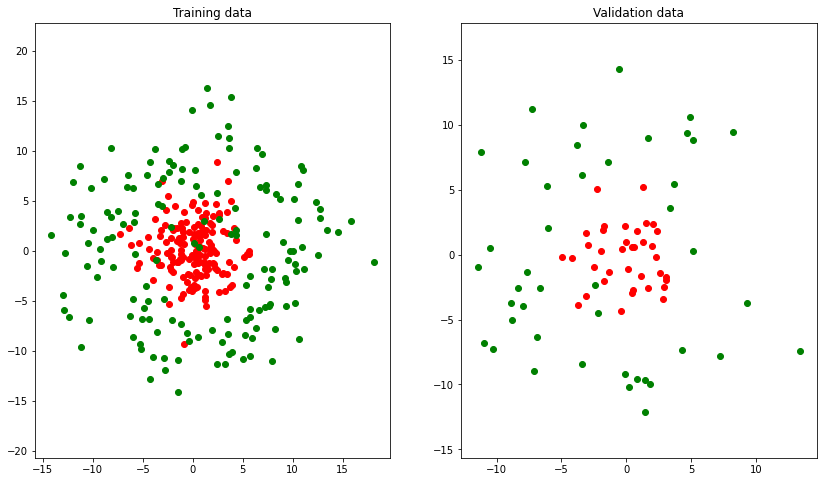

In [3]:
import numpy as np
import math
import cvxopt
import matplotlib.pyplot as plt

N=200

sigma=np.array([[6,0],[0,6]])
mu1 = np.array([0, 0])
X1 = np.random.multivariate_normal(mu1, sigma, N)

theta=np.linspace(0,2*np.pi,N).reshape(N,1)
Rc=10
sigma=3
R=Rc+np.random.normal(0,sigma,(N,1))
X11=R*np.cos(theta)
X12=R*np.sin(theta)
X2=np.concatenate((X11, X12), 1)


#X = np.concatenate((np.ones((2*N, 1)),np.concatenate((X1, X2), 0) ), 1)
X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((N, 1)), np.ones((N, 1))), 0)


def train_val_split(X,y,test_size):
    m=X.shape[0]
    idx=np.arange(m)
    np.random.shuffle(idx)
    m_train=int ((1-test_size)*m)
    train_idx = idx [:m_train]
    val_idx = idx [m_train:]
    X_train = X [train_idx,:]
    X_val = X [val_idx,:]
    y_train = y [train_idx,:]
    y_val = y [val_idx,:]
    return X_train,X_val,y_train,y_val

X_train, X_test, y_train, y_test = train_val_split (X,y,0.2)
def plot_data(X, y, title):
    X_0 = X[(y==-1).flat]
    X_1 = X[(y==1).flat]
    plt.plot(X_0[:,0], X_0[:,1], 'ro')
    plt.plot(X_1[:,0], X_1[:,1], 'go')
    plt.title(title)
    plt.axis('equal')
    
plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1,2, 1)
plot_data(X_train, y_train, 'Training data')
plt.subplot(1,2, 2)
plot_data(X_test, y_test, 'Validation data')

print(X.shape,y.shape)

In [6]:
# Combine the classes and set targets

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    cvxopt.solvers.options['show_progress'] = False
    return np.array(sol['x']).reshape((Q.shape[1],))


def linear_kernel(X):
    return X @ X.T


def rbf_kernel(X, sigma):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = (X[i,:] - X[j,:]) @ (X[i,:] - X[j,:])
    K = np.exp(- K / 2 / sigma / sigma)
    return K
        
# How to perform inference with a kernel rather than w,b?

def b_from_alpha(X, y, alpha, rbf_sigma):
    S = np.where(alpha > 1e-5)[0]
    alpha_s = alpha[S].reshape(-1,1)
    y_s = y[S]
    X_s = X[S,:]
    b = (y_s - ((alpha_s * y_s).T * rbf_kernel(X_s, rbf_sigma)).sum(axis=1, keepdims=True)).mean()
    return b

def rbf_kernel_1(x, xprime, rbf_sigma):
    return np.exp(- (x - xprime) @ (x - xprime) / 2 / rbf_sigma / rbf_sigma)
    
def svm_predict(x, X, y, alpha, rbf_sigma):
    b = b_from_alpha(X, y, alpha, rbf_sigma)
    results = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        results[i] = 0
        for j in range(X.shape[0]):
            results[i, 0] += alpha[j] * y[j, 0] * rbf_kernel_1(x[i,:], X[j,:], rbf_sigma)
        results[i] += b
    return np.sign(results)


In [ ]:
##
rbf_sigma=2
##
m = X_train.shape[0]
rbf_sigma = 0.1
C = 2

c = - np.ones((m, 1))
Q = (y_train @ y_train.T) * rbf_kernel(X_train, rbf_sigma)
A = np.concatenate((-np.eye(m), np.eye(m)), 0)
b = np.concatenate((np.zeros((m, 1)), np.ones((m, 1)) * C), 0)
E = y_train.T
d = np.zeros((1, 1))
##
opt_params=cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None)
result=svm_predict(X_test, X_train, y_train, opt_params, rbf_sigma)
np.unique(result)
result.sum()

In [5]:
def accuracy_score (x, X, y_0, y,rbf_sigma,C):
    m = X.shape[0]
    c = - np.ones((m, 1))
    A = np.concatenate((-np.eye(m), np.eye(m)), 0)
    b = np.concatenate((np.zeros((m, 1)), np.ones((m, 1)) * C), 0)
    E = y.T
    d = np.zeros((1, 1))
    Q = (y @ y.T) * rbf_kernel(X, rbf_sigma)
    opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)
    pred = svm_predict(x, X, y, opt_params, rbf_sigma)
    #print(pred.shape)
    accuracy = (pred == y_0).mean()
    return accuracy,opt_params



In [8]:
rbf_sigma_2d_range = np.logspace(-2, 10, 13)
C_2d_range = np.logspace(-9, 3, 13)

test_scores=[]
train_scores=[]
for C in C_2d_range:
    for rbf_sigma in rbf_sigma_2d_range:
        classifiers.append((C, rbf_sigma))
        test_score,_=accuracy_score(X_test,X_train,y_test,y_train,rbf_sigma,C)
        train_score,_=accuracy_score(X_train,X_train,y_train,y_train,rbf_sigma,C)
        test_scores.append(test_score)
        train_scores.append(train_score)

/var/folders/gq/3rtsgkd97h7djl6gyntg3f3r0000gn/T/ipykernel_6427/1877860964.py:37: RuntimeWarning: Mean of empty slice.
  b = (y_s - ((alpha_s * y_s).T * rbf_kernel(X_s, rbf_sigma)).sum(axis=1, keepdims=True)).mean()
/Users/yhuynh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


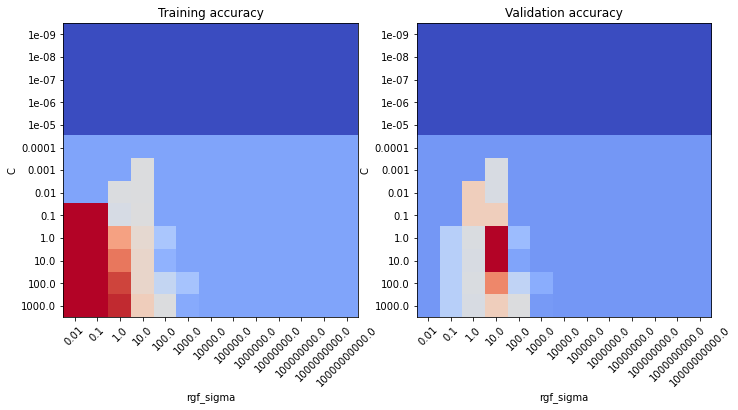

In [25]:
scores_test=np.array(test_scores).reshape(len(C_2d_range), len(rbf_sigma_2d_range))
scores_train=np.array(train_scores).reshape(len(C_2d_range), len(rbf_sigma_2d_range))

from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.figure(figsize=(12,12))
plt.subplot(1,2,2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores_test,
    interpolation="nearest",
    cmap=plt.cm.coolwarm,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("rgf_sigma")
plt.ylabel("C")
#plt.colorbar()
plt.xticks(np.arange(len(rbf_sigma_2d_range)), rbf_sigma_2d_range, rotation=45)
plt.yticks(np.arange(len(C_2d_range)), C_2d_range)
plt.title("Validation accuracy")
#plt.show()

plt.subplot(1,2,1)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores_train,
    interpolation="nearest",
    cmap=plt.cm.coolwarm,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("rgf_sigma")
plt.ylabel("C")
#plt.colorbar()
plt.xticks(np.arange(len(rbf_sigma_2d_range)), rbf_sigma_2d_range, rotation=45)
plt.yticks(np.arange(len(C_2d_range)), C_2d_range)
plt.title("Training accuracy")
plt.show()

In [7]:
rbf_sigma_2d_range = [1e-1, 1, 1e1,1e2]
C_2d_range = [1e-2,1e-1, 1,1e1]
classifiers = []
test_scores = []
for C in C_2d_range:
    for rbf_sigma in rbf_sigma_2d_range:
        classifiers.append((C, rbf_sigma))
        test_score,_=accuracy_score(X_test,X_train,y_test,y_train,rbf_sigma,C)
        test_scores.append(test_score)

     pcost       dcost       gap    pres   dres
 0: -8.8363e+01 -2.3857e+01  1e+03  4e+01  2e-16
 1: -1.5939e+01 -6.7408e+00  6e+01  2e+00  5e-16
 2: -2.8589e+00 -5.9688e+00  3e+00  2e-16  1e-15
 3: -3.0839e+00 -3.2508e+00  2e-01  2e-16  3e-16
 4: -3.1235e+00 -3.1324e+00  9e-03  2e-16  2e-16
 5: -3.1239e+00 -3.1252e+00  1e-03  2e-16  2e-16
 6: -3.1238e+00 -3.1252e+00  1e-03  1e-16  3e-16
 7: -3.1239e+00 -3.1248e+00  9e-04  2e-16  2e-16
 8: -3.1241e+00 -3.1243e+00  2e-04  1e-16  7e-16
 9: -3.1242e+00 -3.1242e+00  2e-05  2e-16  2e-16
10: -3.1242e+00 -3.1242e+00  1e-06  8e-17  2e-16
Optimal solution found.


In [ ]:
rbf_sigma_2d_range = [1e-1, 1, 1e1,1e2]
C_2d_range = [1e-2,1e-1, 1,1e1]

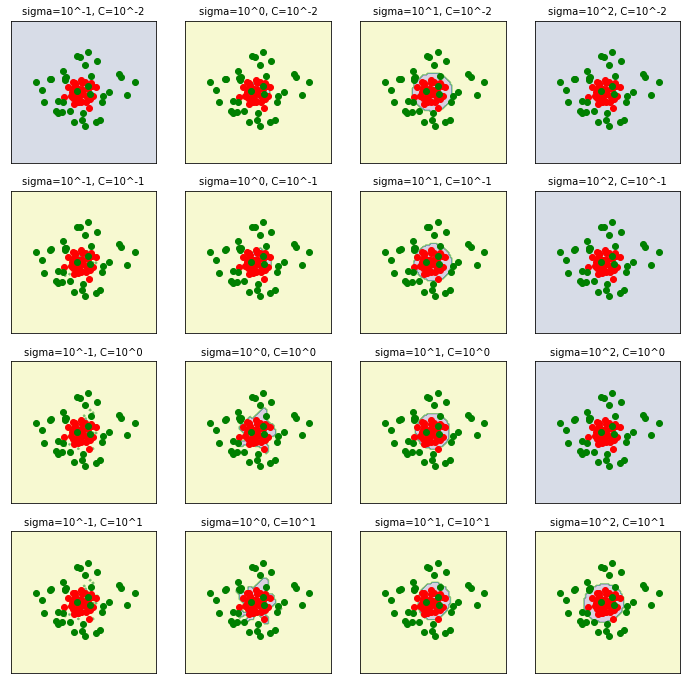

In [228]:
# plt.plot((x11, x12), (x21, x22), 'k-')
from matplotlib.colors import ListedColormap
custom_cmap =ListedColormap(['#ffccff','#b3fff0','#ff9999','#9fff80'])
plt.figure(figsize = (12,12))



# Overlay colored regions according to svm_predict

grid_x, grid_y = np.mgrid[-25:25:100j, -25:25:100j]

for k, (C, rbf_sigma) in enumerate(classifiers):
    _,opt_params = accuracy_score (X_test, X_train, y_test, y_train,rbf_sigma,C)

    grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    grid_z = svm_predict(grid_xy, X_train, y_train, opt_params, rbf_sigma).reshape((100, 100))

    plt.subplot(len(C_2d_range), len(rbf_sigma_2d_range), k+1 )
    plt.contourf(grid_x, grid_y, grid_z, alpha=0.2)
    plt.scatter(X_test[(y_test==-1).flat][:,0], X_test[(y_test==-1).flat][:,1], marker='o',color='red', label='Class 0')
    plt.scatter(X_test[(y_test==1).flat][:,0], X_test[(y_test==1).flat][:,1], marker='o',color='green', label='Class 1')
    
    plt.title("sigma=10^%d, C=10^%d" % (np.log10(rbf_sigma), np.log10(C)), size="medium")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")